In [1]:
import numpy as np
import pandas as pd

In [2]:
# !pip install lifelines
# !pip install ISLP

In [3]:
from ISLP.models import ModelSpec as MS
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns; sns.set()

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

In [4]:
data = pd.read_csv('Q2_odd.csv')

In [5]:
data

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
0,0,0,1,R01,39876,8.016941,44.016,11.203285,1
1,0,0,1,R01,39876,8.016941,23.494,15.178645,1
2,0,0,1,R01,8171,7.612606,8.391,24.410678,1
3,0,0,1,Contract,24335,11.771928,15.402,2.595483,1
4,0,0,1,Contract,33357,76.517537,16.783,8.607803,1
...,...,...,...,...,...,...,...,...,...
117,0,0,0,R01,239,1.600511,3.873,39.950719,1
118,0,0,0,R01,249,1.869710,1.438,17.051335,1
119,1,0,0,R01,201,1.747354,3.873,39.195072,1
120,1,0,0,R01,182,4.232768,7.508,18.398357,1


__a. Plot the survival curve for the dataset__

Text(0.5, 1.0, 'Survival curve')

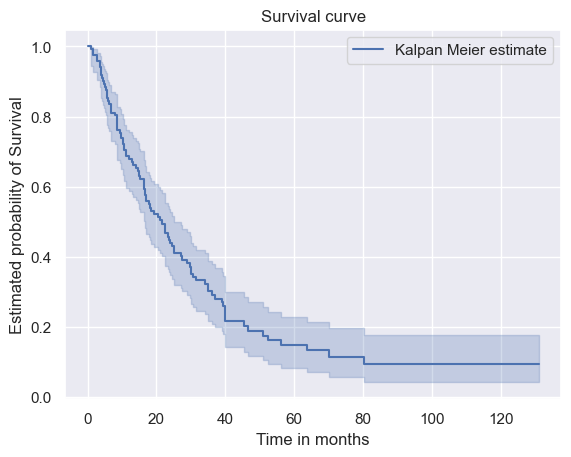

In [6]:
# Creating new object
km = KaplanMeierFitter()
# Fitting the data to the estimator and visualizing the survival curve
# Pointwise Confidence interval is set to 90% by default
km_brain = km.fit(data['time'], data['status'])
km_brain.plot(label = 'Kalpan Meier estimate')
plt.xlabel('Time in months')
plt.ylabel('Estimated probability of Survival')
plt.title('Survival curve')

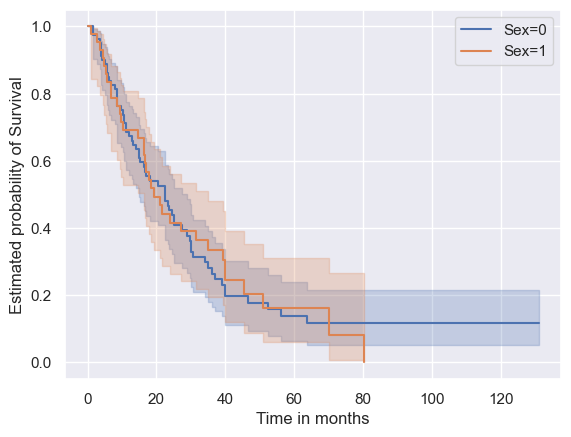

In [7]:
# Initializing a directory to store data frames for each sex category
by_mech = {}

for sex, df in data.groupby('posres'):
    by_mech[sex] = df
    # Fitting the data to the estimator and visualizing the survival curve
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label = 'Sex=%s' % sex)
    plt.xlabel('Time in months')
    plt.ylabel('Estimated probability of Survival')

In [8]:
# by_mech

__b. Perform log-rank test and report the p-value__

In [9]:
logrank_test(by_mech[0]['time'], by_mech[1]['time'], by_mech[0]['status'], by_mech[1]['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.97      0.05

__c. Fit the data to the Cox’s proportional hazards model with linear and
nonlinear terms for the hazard function h(t/xi). The nonlinear terms should
be xixj form, for example, x1
2
, x2
2
,…, x1x3, x2x3,…..__

In [10]:
coxph = CoxPHFitter
sex_df = data[['time', 'status', 'posres']]
# Design matrix for the Cox model using model specification class (MS) with sex as the only predictor
model_df = MS(['time', 'status', 'posres'],intercept=False).fit_transform(sex_df)
cox_fit = coxph().fit(model_df , 'time','status')
# cox_fit.summary[['coef', 'se(coef)', 'p']]
cox_fit.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
posres,-0.008852,0.991187,0.213986,-0.428257,0.410553,0.651644,1.507651,0.0,-0.041368,0.967003,0.048408


__d. Determine the significant contribution of the variables__

In [11]:
data.columns

Index(['posres', 'multi', 'clinend', 'mech', 'sampsize', 'budget', 'impact',
       'time', 'status'],
      dtype='object')

In [12]:
# cleaning the data
cleaned = data.dropna()
cleaned = cleaned.drop(columns=['mech'])
# Design matrix
all_MS = MS(cleaned.columns , intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df ,'time','status')
fit_all.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
posres,0.501158,1.650631,0.233445,0.043614,0.958702,1.044579,2.608309,0.0,2.146790,3.181001e-02,4.974375
multi,-0.031527,0.968965,0.290175,-0.600260,0.537206,0.548669,1.711220,0.0,-0.108648,9.134819e-01,0.130552
clinend,0.493307,1.637724,0.313078,-0.120315,1.106929,0.886641,3.025056,0.0,1.575668,1.151024e-01,3.119010
sampsize,0.000007,1.000007,0.000014,-0.000021,0.000035,0.999979,1.000035,0.0,0.471950,6.369624e-01,0.650720
budget,0.003589,1.003596,0.002515,-0.001341,0.008519,0.998660,1.008556,0.0,1.426866,1.536186e-01,2.702575
impact,0.052859,1.054281,0.008889,0.035437,0.070280,1.036073,1.072809,0.0,5.946755,2.735111e-09,28.445753


In [13]:
# Null model (with no features)
cox_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.00 0.97      0.05